In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%store -r core_coral
%store -r octo_sto
%store -r octo_sto_coords
%store -r core_coral_env


# EDA - Temporal Trends

In [2]:
%store -r core_coral

core_coral.head()

,StationID,Date,Pseudopterogorgia_americana,Total_Octocorals,Siderastrea_siderea,Siderastrea_siderea_scor_lta,Siderastrea_siderea_scor_density,sciName,Count,SiteID,Site_name,Octocoral,Stony_coral,Substrate,Siderastrea_siderea_scor_cover
0,321,2011-06-08,23.8,9.0,18.0,7324.5,1.8,Dichocoenia stokesii,4.0,32.0,Porter Patch,0.1322,0.0416,0.4957,0.0288
1,321,2011-06-08,23.8,9.0,18.0,7324.5,1.8,Montastraea cavernosa,1.0,32.0,Porter Patch,0.1322,0.0416,0.4957,0.0288
2,321,2011-06-08,23.8,9.0,18.0,7324.5,1.8,Porites astreoides,4.0,32.0,Porter Patch,0.1322,0.0416,0.4957,0.0288
3,321,2011-06-08,23.8,9.0,18.0,7324.5,1.8,Porites porites,8.0,32.0,Porter Patch,0.1322,0.0416,0.4957,0.0288
4,321,2011-06-08,23.8,9.0,18.0,7324.5,1.8,Siderastrea radians,1.0,32.0,Porter Patch,0.1322,0.0416,0.4957,0.0288


### Stony Coral Percent Cover Analysis

Calculate average percent stony coral cover over time per station, plot time series, and highlight key shifts (e.g., due to bleaching or hurricanes)

In [3]:
# Assuming your DataFrame is called `temporal_trend_data`
df = core_coral.copy()

# Ensure Date is in datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Extract year
df['Year'] = df['Date'].dt.year

# Filter for 1996 onward
df = df[df['Year'] >= 1996]

# Keep only relevant columns
df_subset = df[['StationID', 'Year', 'Stony_coral']]

df_subset.head()

,StationID,Year,Stony_coral
0,321,2011,0.0416
1,321,2011,0.0416
2,321,2011,0.0416
3,321,2011,0.0416
4,321,2011,0.0416


In [4]:
# Group and Aggregate: 
# Average Percent Cover Per Station Per Year

# Group by Station and Year to get mean stony coral cover
avg_cover = (
    df_subset
    .groupby(['StationID', 'Year'])['Stony_coral']
    .mean()
    .reset_index()
)


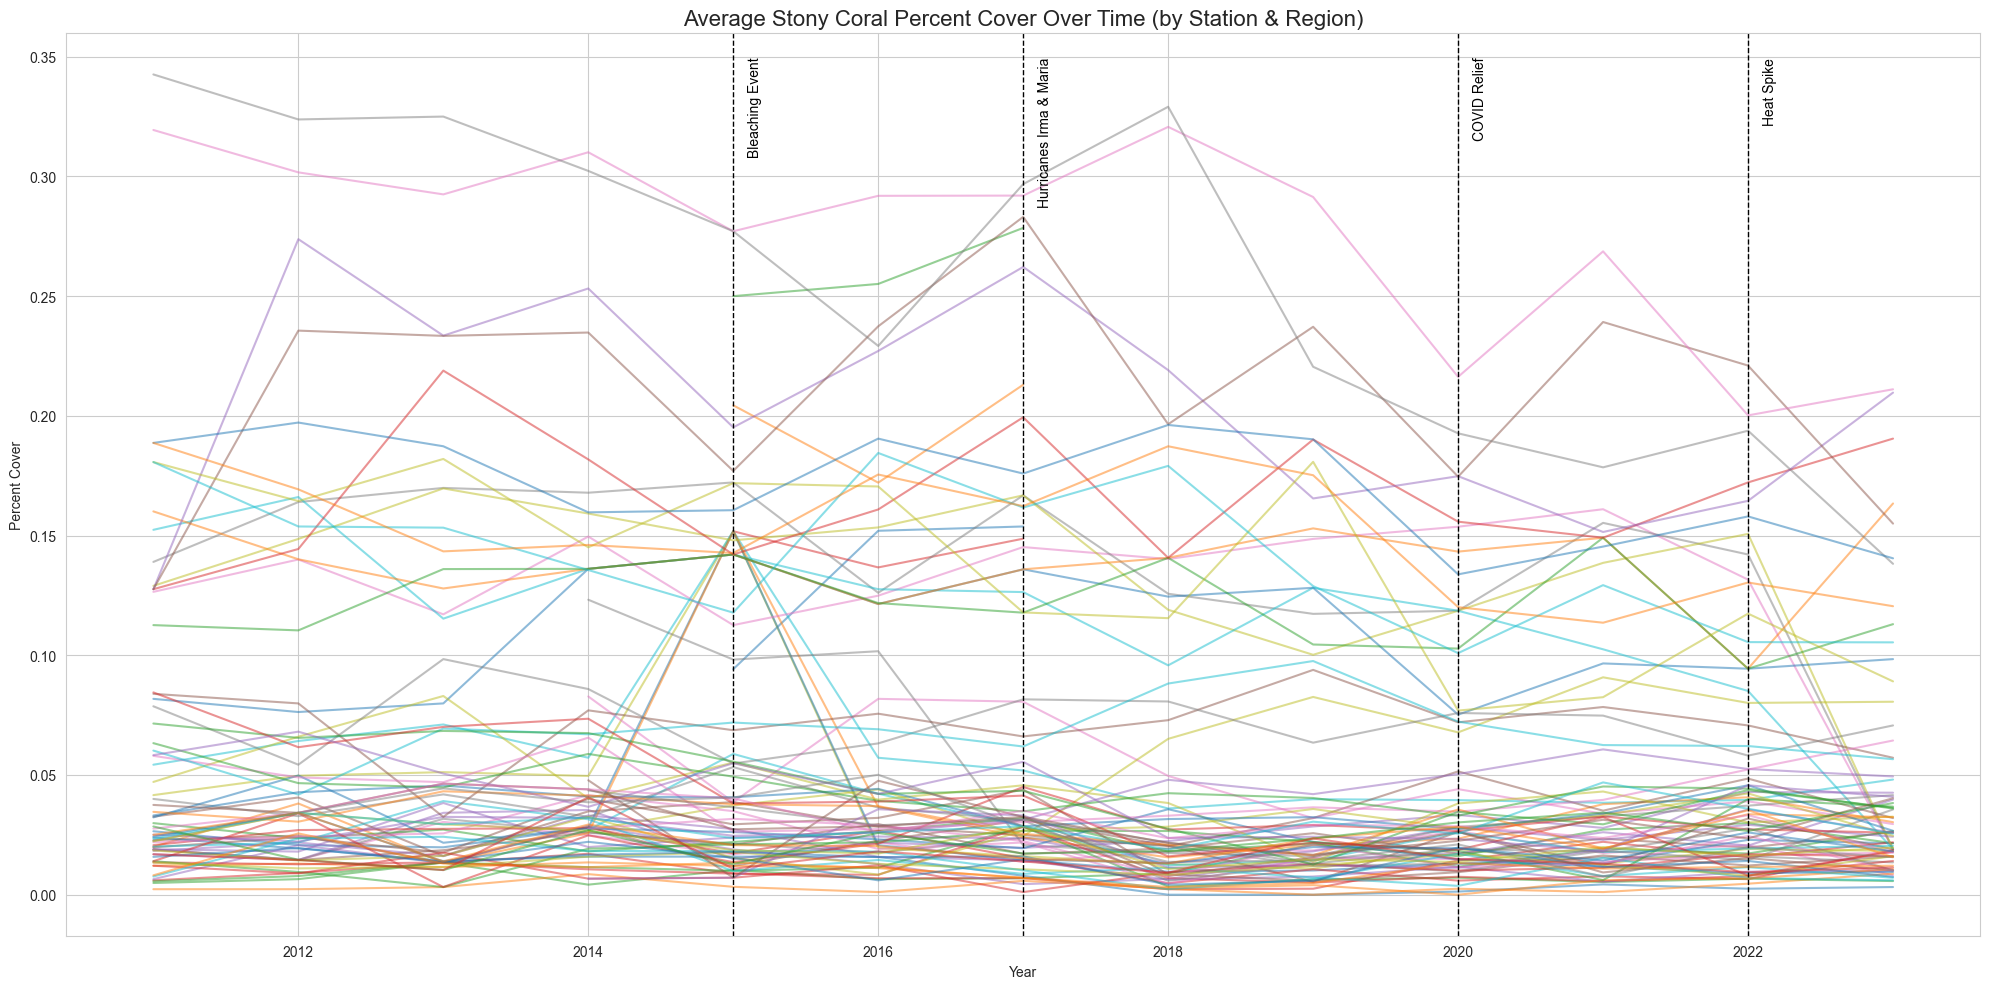

In [5]:


# --- Assign regions based on StationID ---
def assign_region(station_id):
    if 300 <= station_id < 400:
        return 'North'
    elif 400 <= station_id < 500:
        return 'Central'
    elif 500 <= station_id < 600:
        return 'South'
    elif 600 <= station_id < 700:
        return 'East'
    elif 700 <= station_id < 800:
        return 'West'
    else:
        return 'Unknown'

df['Region'] = df['StationID'].apply(assign_region)

# --- Group by Station and Year to get average stony coral percent cover ---
grouped = df.groupby(['StationID', 'Year', 'Region'])['Stony_coral'].mean().reset_index()

# --- Plot ---
plt.figure(figsize=(20, 10))
sns.set_style('whitegrid')

for region in grouped['Region'].unique():
    region_data = grouped[grouped['Region'] == region]
    for station_id in region_data['StationID'].unique():
        station_data = region_data[region_data['StationID'] == station_id]
        plt.plot(station_data['Year'], station_data['Stony_coral'], label=region, alpha=0.5)

# --- Annotate significant events ---
events = {
    2015: 'Bleaching Event',
    2017: 'Hurricanes Irma & Maria',
    2020: 'COVID Relief',
    2022: 'Heat Spike'
}

for year, label in events.items():
    plt.axvline(x=year, color='black', linestyle='--', linewidth=1)
    plt.text(year + 0.1, 0.35, label, rotation=90, va='top', fontsize=10, color='black')

plt.title('Average Stony Coral Percent Cover Over Time (by Station & Region)', fontsize=16)
plt.xlabel('Year')
plt.ylabel('Percent Cover')
plt.tight_layout()
plt.show()


### Octocoral Density Variation


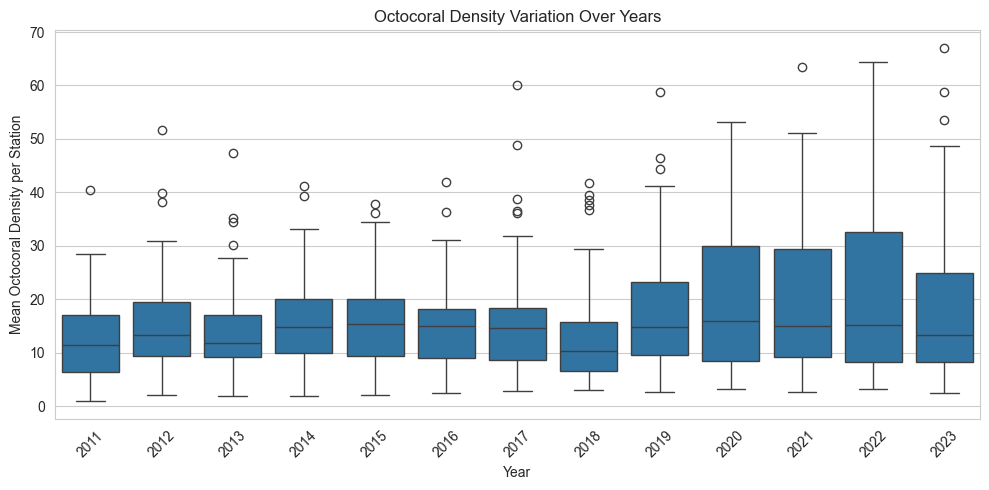

In [6]:
# Aggregate Octocoral Density by Station & Year

octo_density = df.groupby(['StationID', 'Year'])['Total_Octocorals'].mean().reset_index()
# octo_density.head()

plt.figure(figsize=(10, 5))
sns.boxplot(data=octo_density, x='Year', y='Total_Octocorals')
plt.title("Octocoral Density Variation Over Years")
plt.xlabel("Year")
plt.ylabel("Mean Octocoral Density per Station")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Spatial Map — Density by Station

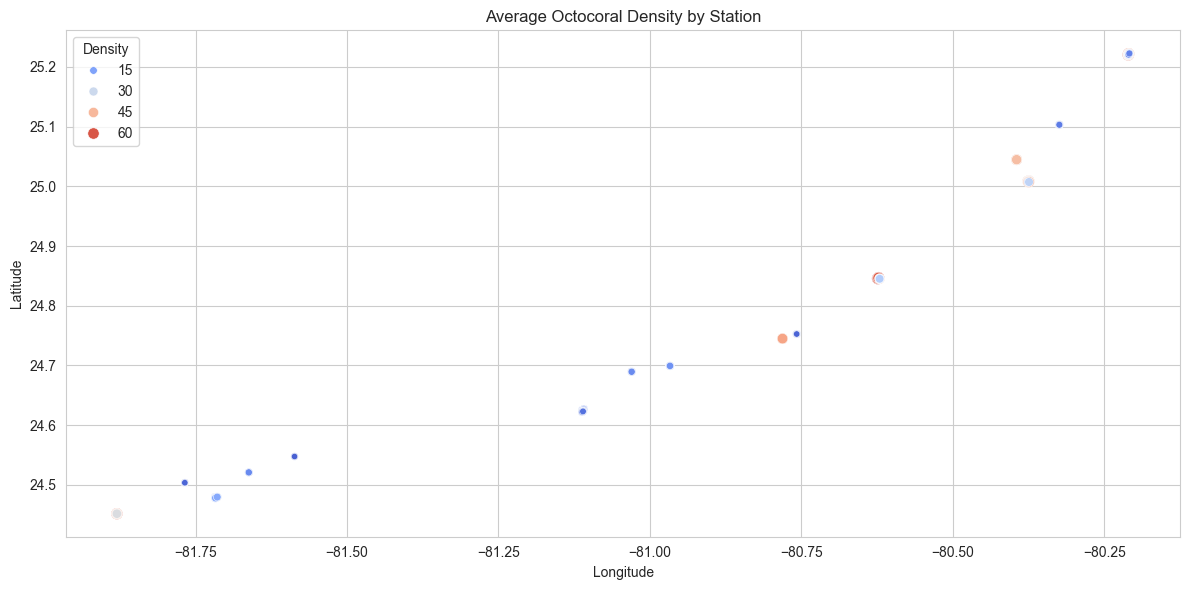

In [7]:
# Assuming df_coords has StationID, latDD, lonDD
octo_map = octo_density.merge(octo_sto_coords[['StationID', 'latDD', 'lonDD']].drop_duplicates(), on='StationID', how='left')

plt.figure(figsize=(12, 6))
sns.scatterplot(data=octo_map, x='lonDD', y='latDD', hue='Total_Octocorals', size='Total_Octocorals', palette='coolwarm')
plt.title("Average Octocoral Density by Station")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend(title='Density')
plt.tight_layout()
plt.show()


### Density Change Per Station

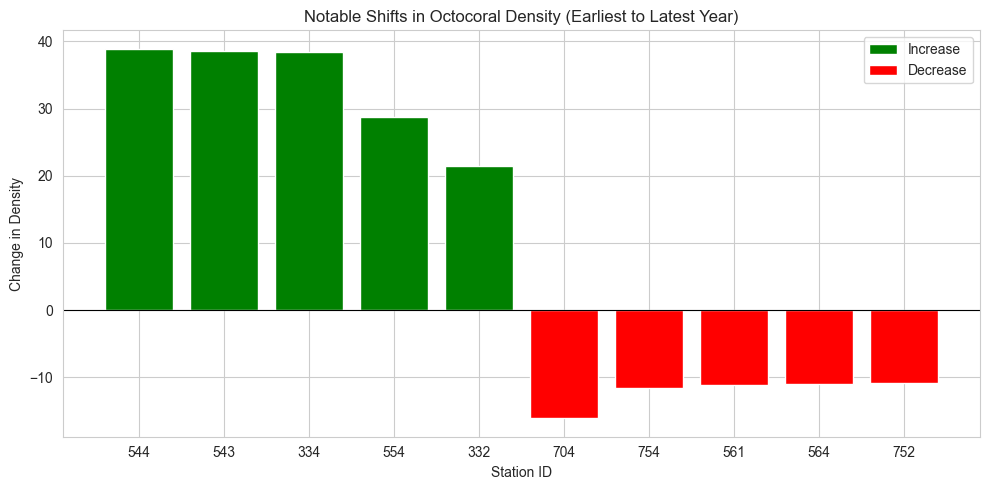

In [8]:
pivot = octo_density.pivot(index='StationID', columns='Year', values='Total_Octocorals')
pivot['Change'] = pivot[pivot.columns[-1]] - pivot[pivot.columns[0]]


# Get top 5 increasing and decreasing stations
top_increase = pivot.sort_values('Change', ascending=False).head(5)
top_decrease = pivot.sort_values('Change').head(5)

plt.figure(figsize=(10, 5))

# Plot increasing
plt.bar(top_increase.index.astype(str), top_increase['Change'], color='green', label='Increase')

# Plot decreasing
plt.bar(top_decrease.index.astype(str), top_decrease['Change'], color='red', label='Decrease')

plt.axhline(0, color='black', linewidth=0.8)
plt.title("Notable Shifts in Octocoral Density (Earliest to Latest Year)")
plt.ylabel("Change in Density")
plt.xlabel("Station ID")
plt.legend()
plt.tight_layout()
plt.show()

# EDA Spatial Patterns

In [9]:
%store -r octo_sto
octo_sto.head()

,StationID,Date,Habitat,Subregion,SPP_Code,SiteID,Height_cm,Diameter_cm,Height_cm_scor,Percent_old_mortality,Percent_recent_mortality,LTA_cm2
0,321,2011-06-08,P,UK,PAME,32,9.0,4.0,1.0,0.0,0.0,17.36
1,321,2011-06-08,P,UK,PAME,32,9.0,7.0,2.0,0.0,0.0,56.27
2,321,2011-06-08,P,UK,PAME,32,9.0,9.0,3.0,0.0,0.0,100.16
3,321,2011-06-08,P,UK,PAME,32,9.0,12.0,8.0,15.0,0.0,236.18
4,321,2011-06-08,P,UK,PAME,32,9.0,5.0,1.0,0.0,0.0,25.07


# EDA Getting Site Coordinate 
Spatial Pattern + Station Data

In [10]:
%store -r octo_sto_coords

octo_sto_coords.head()

,StationID,Date,Habitat_x,Subregion,SPP_Code,SiteID,Height_cm,Diameter_cm,Height_cm_scor,Percent_old_mortality,Percent_recent_mortality,LTA_cm2,Site_name,latDD,lonDD,Depth_ft,length_m,Habitat_y,Reef_Type
0,321,2011-06-08,P,UK,PAME,32,9.0,4.0,1.0,0.0,0.0,17.36,Porter Patch,25.1032,-80.3243,15,24,P,Shallow
1,321,2011-06-08,P,UK,PAME,32,9.0,4.0,1.0,0.0,0.0,17.36,Porter Patch,25.1032,-80.3243,14,23,P,Shallow
2,321,2011-06-08,P,UK,PAME,32,9.0,4.0,1.0,0.0,0.0,17.36,Porter Patch,25.1032,-80.3243,16,23,P,Shallow
3,321,2011-06-08,P,UK,PAME,32,9.0,4.0,1.0,0.0,0.0,17.36,Porter Patch,25.1032,-80.3243,17,25,P,Shallow
4,321,2011-06-08,P,UK,PAME,32,9.0,7.0,2.0,0.0,0.0,56.27,Porter Patch,25.1032,-80.3243,15,24,P,Shallow


In [11]:
# Extract Year from Date

osc = octo_sto_coords.copy()


# Convert Date to datetime and extract Year
osc['Date'] = pd.to_datetime(osc['Date'])
osc['Year'] = osc['Date'].dt.year


#### Compute Species Richness Per Station Per Year

In [12]:
# Compute Species Richness Per Station Per Year
# Species richness = count of unique SPP_Code per StationID per Year.

species_richness = osc.groupby(['StationID', 'Year'])['SPP_Code'].nunique().reset_index()
species_richness.rename(columns={'SPP_Code': 'SpeciesRichness'}, inplace=True)
species_richness.head()

,StationID,Year,SpeciesRichness
0,261,2015,5
1,261,2016,4
2,261,2017,5
3,262,2015,5
4,262,2016,5


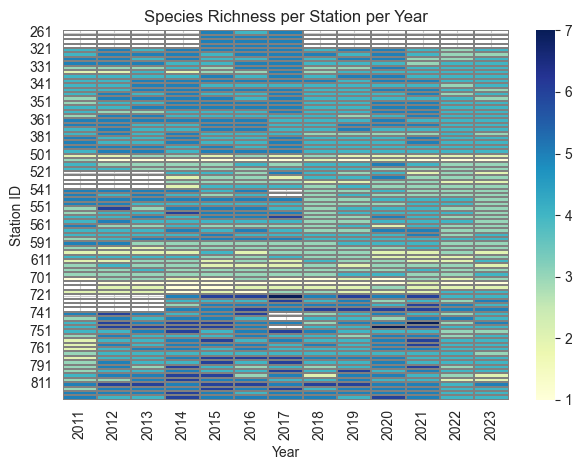

In [13]:
pivot_table = species_richness.pivot(index='StationID', columns='Year', values='SpeciesRichness')
sns.heatmap(pivot_table, cmap='YlGnBu', linewidths=0.3, linecolor='gray')
plt.title("Species Richness per Station per Year")
plt.xlabel("Year")
plt.ylabel("Station ID")
plt.tight_layout()
plt.show()


#### Identify Notable Changes (Stations with biggest increase/decrease)

In [14]:
trend = species_richness.sort_values(by=['StationID', 'Year'])
trend_summary = trend.groupby('StationID')['SpeciesRichness'].agg(['first', 'last'])
trend_summary['Change'] = trend_summary['last'] - trend_summary['first']
trend_summary = trend_summary.sort_values(by='Change', ascending=False)

# Top 5 increases and decreases
print("Top increasers:\n", trend_summary.head())
print("Top decreasers:\n", trend_summary.tail())


Top increasers:
            first  last  Change
StationID                     
763            2     4       2
611            2     4       2
753            2     4       2
754            2     4       2
701            1     3       2
Top decreasers:
            first  last  Change
StationID                     
543            5     3      -2
544            5     3      -2
793            4     2      -2
561            5     3      -2
591            5     3      -2


#### Map coral species distribution (stony and octocoral) across stations

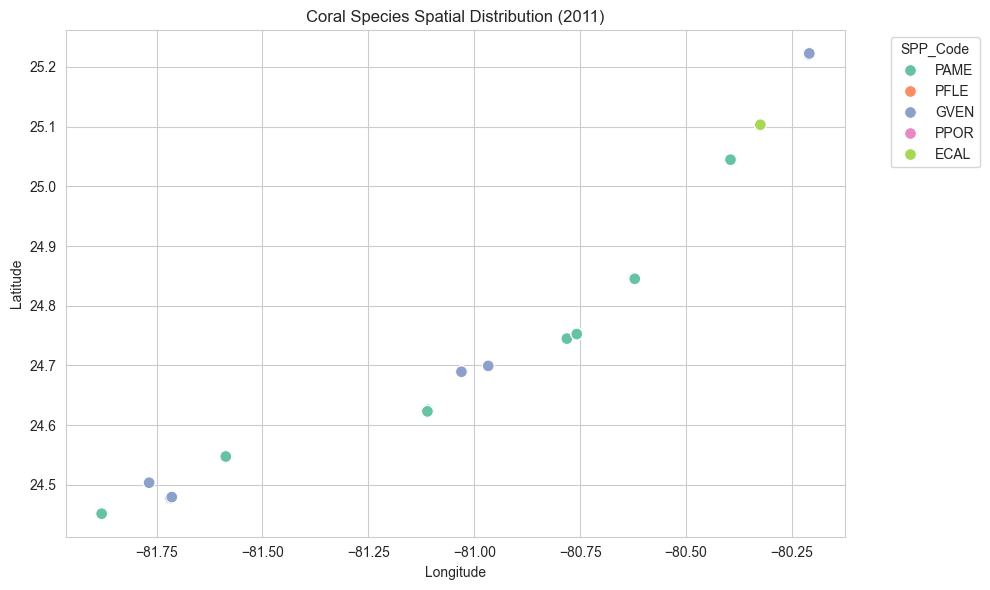

In [15]:
##osc
#osc['Year'] = pd.to_datetime(osc['Date']).dt.year

import matplotlib.pyplot as plt
import seaborn as sns

# Example: Filter for 2011
df_2011 = osc[osc['Year'] == 2011]

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_2011, x='lonDD', y='latDD', hue='SPP_Code', palette='Set2', s=70)
plt.title('Coral Species Spatial Distribution (2011)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.legend(title='SPP_Code', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


### Side-by-Side Yearly Comparison
Compare e.g., 2011 vs 2023

In [16]:

# Aggregate by StationID and Year
station_year_agg = osc.groupby(['StationID', 'Year']).agg({
    'Height_cm': 'mean',      # Average octocoral height as a proxy for density/presence
    'LTA_cm2': 'mean',        # Average stony coral living tissue area
    'latDD': 'mean',          # Average latitude (to handle slight variations)
    'lonDD': 'mean',          # Average longitude
    'Subregion': 'first',     # Keep Subregion for context
    'Habitat_x': 'first',     # Keep Habitat for context
    'Site_name': 'first'      # Keep Site_name for labels
}).reset_index()

# Filter for 2011 and 2023
data_2011 = station_year_agg[station_year_agg['Year'] == 2011]
data_2023 = station_year_agg[station_year_agg['Year'] == 2023]

# Check the aggregated data
print("2011 Data Sample:\n", data_2011.head())
print("2023 Data Sample:\n", data_2023.head())

2011 Data Sample:
     StationID  Year  Height_cm     LTA_cm2    latDD    lonDD Subregion  \
12        321  2011  23.650000  241.269524  25.1032 -80.3243        UK   
25        322  2011  36.083333  760.207619  25.1032 -80.3243        UK   
38        323  2011  28.166667  129.853704  25.1032 -80.3243        UK   
51        324  2011  26.414634  228.970227  25.1032 -80.3243        UK   
64        331  2011  21.000000  597.170000  25.0447 -80.3948        UK   

   Habitat_x     Site_name  
12         P  Porter Patch  
25         P  Porter Patch  
38         P  Porter Patch  
51         P  Porter Patch  
64         P       Admiral  
2023 Data Sample:
     StationID  Year  Height_cm     LTA_cm2    latDD    lonDD Subregion  \
24        321  2023  27.353659  159.026364  25.1032 -80.3243        UK   
37        322  2023  30.400000  968.640213  25.1032 -80.3243        UK   
50        323  2023  21.656716  210.366471  25.1032 -80.3243        UK   
63        324  2023  25.175439  131.697895  25.

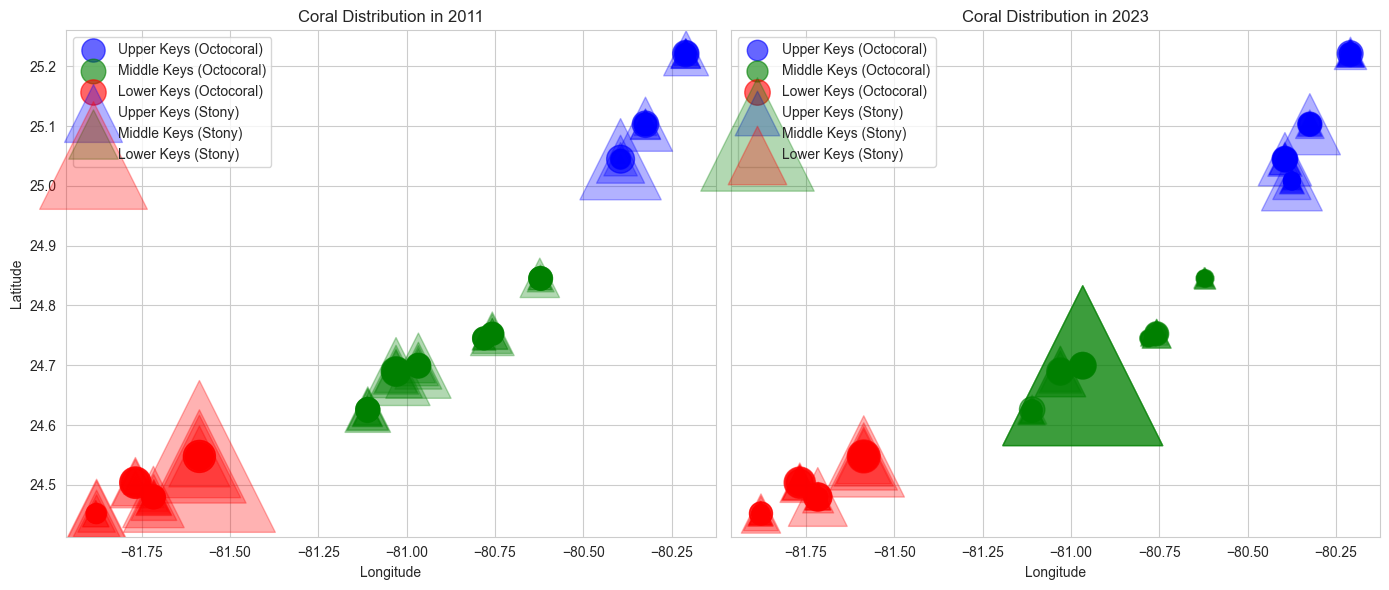

In [17]:
# Set up the figure with two subplots (side-by-side)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), sharex=True, sharey=True)

# Define a color map for Subregion
subregion_colors = {'UK': 'blue', 'MK': 'green', 'LK': 'red'}  # Adjust based on actual Subregions
subregion_labels = {'UK': 'Upper Keys', 'MK': 'Middle Keys', 'LK': 'Lower Keys'}

# --- 2011 Plot (Left) ---
# Plot octocorals (Height_cm)
for subregion in subregion_colors:
    subset = data_2011[data_2011['Subregion'] == subregion]
    ax1.scatter(
        subset['lonDD'], subset['latDD'],
        s=subset['Height_cm'] * 10,  # Scale size for visibility
        c=subregion_colors[subregion], alpha=0.6, label=f"{subregion_labels[subregion]} (Octocoral)",
        marker='o'
    )

# Plot stony corals (LTA_cm2) with a different marker
for subregion in subregion_colors:
    subset = data_2011[data_2011['Subregion'] == subregion]
    ax1.scatter(
        subset['lonDD'], subset['latDD'],
        s=subset['LTA_cm2'] * 2,  # Scale size differently for stony corals
        c=subregion_colors[subregion], alpha=0.3, label=f"{subregion_labels[subregion]} (Stony)",
        marker='^'
    )

ax1.set_title('Coral Distribution in 2011')
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')
ax1.legend()
ax1.grid(True)

# --- 2023 Plot (Right) ---
# Plot octocorals
for subregion in subregion_colors:
    subset = data_2023[data_2023['Subregion'] == subregion]
    ax2.scatter(
        subset['lonDD'], subset['latDD'],
        s=subset['Height_cm'] * 10,
        c=subregion_colors[subregion], alpha=0.6, label=f"{subregion_labels[subregion]} (Octocoral)",
        marker='o'
    )

# Plot stony corals
for subregion in subregion_colors:
    subset = data_2023[data_2023['Subregion'] == subregion]
    ax2.scatter(
        subset['lonDD'], subset['latDD'],
        s=subset['LTA_cm2'] * 2,
        c=subregion_colors[subregion], alpha=0.3, label=f"{subregion_labels[subregion]} (Stony)",
        marker='^'
    )

ax2.set_title('Coral Distribution in 2023')
ax2.set_xlabel('Longitude')
ax2.legend()
ax2.grid(True)

# Adjust layout and save
plt.tight_layout()
plt.savefig('coral_distribution_2011_2023.png')
plt.show()

ANOVA F-statistic: 8526.76, p-value: 0.0000
✅ Statistically significant differences in living tissue area across stations.


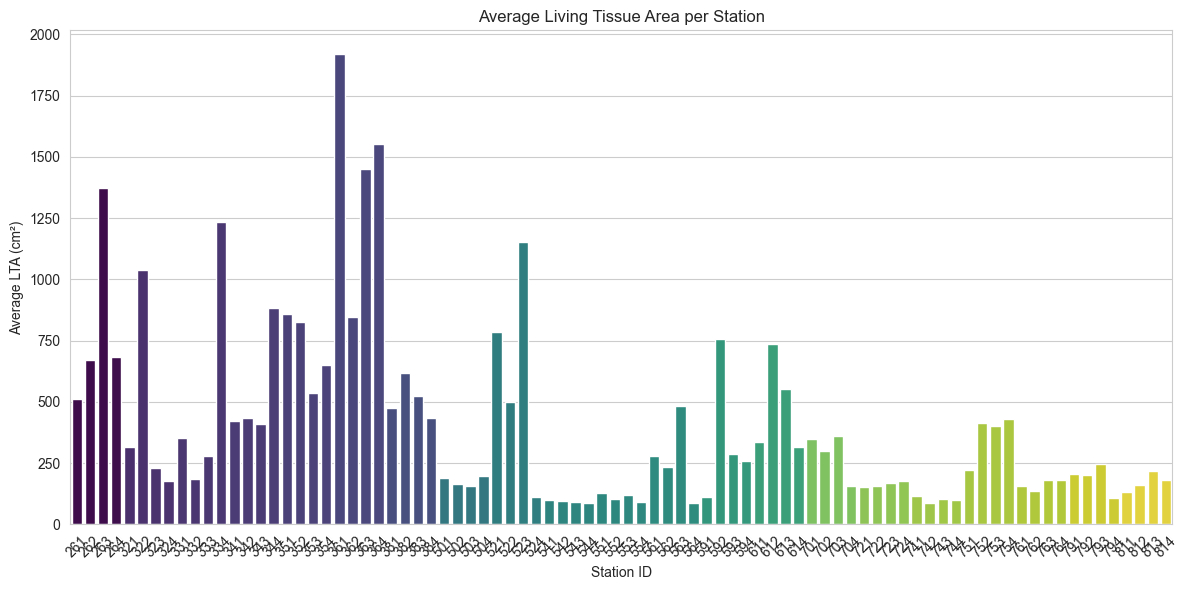

In [19]:

from scipy.stats import f_oneway

# Clean and prepare
df = osc.copy()
df = df.dropna(subset=["LTA_cm2", "StationID"])

# Group by station for ANOVA
grouped = [group["LTA_cm2"].values for name, group in df.groupby("StationID")]

# Perform ANOVA
f_stat, p_val = f_oneway(*grouped)
print(f"ANOVA F-statistic: {f_stat:.2f}, p-value: {p_val:.4f}")
if p_val < 0.05:
    print("✅ Statistically significant differences in living tissue area across stations.")
else:
    print("⚠️ No statistically significant difference between stations.")

# Average LTA per station
station_avg = df.groupby("StationID")["LTA_cm2"].mean().reset_index()

# Bar Chart
plt.figure(figsize=(12, 6))
sns.barplot(data=station_avg, x="StationID", y="LTA_cm2", hue="StationID", palette="viridis", legend=False)
plt.title("Average Living Tissue Area per Station")
plt.xlabel("Station ID")
plt.ylabel("Average LTA (cm²)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()




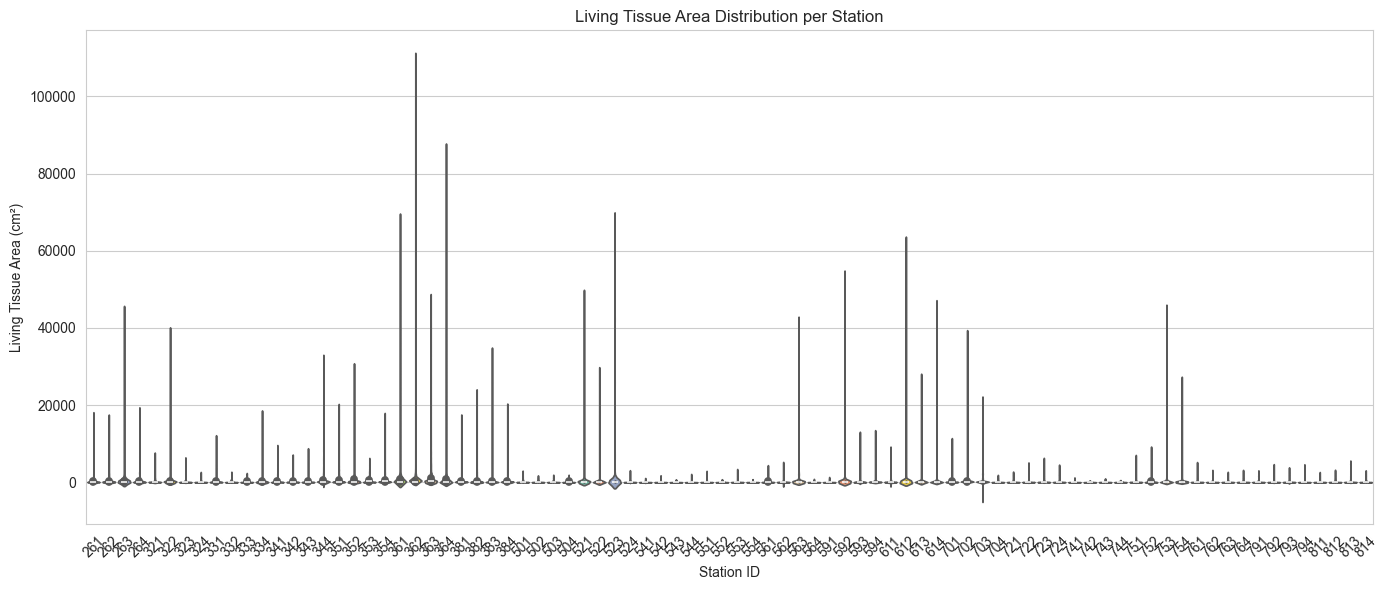

In [20]:
# Violin Plot
plt.figure(figsize=(14, 6))
sns.violinplot(data=df, x="StationID", y="LTA_cm2", hue="StationID", inner="box", palette="Set2", legend=False)
plt.title("Living Tissue Area Distribution per Station")
plt.xlabel("Station ID")
plt.ylabel("Living Tissue Area (cm²)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#  Relationships, Regional Comparisons, and Future Outlook Setup

### Stony Coral Density vs. Richness

📊 Pearson Correlation Coefficient: -0.05, p-value: 0.8146
⚠️ No statistically significant correlation.


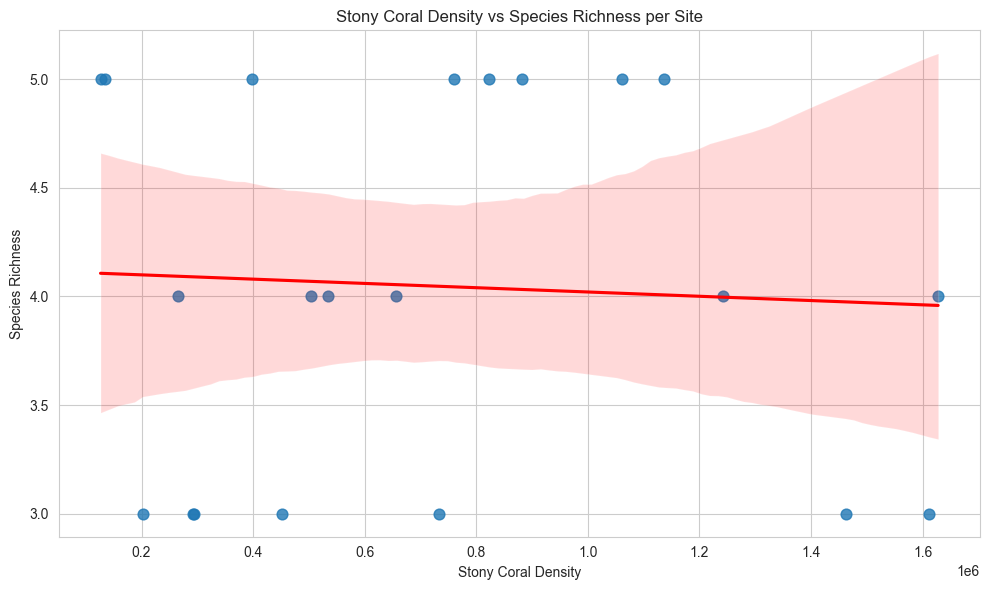

In [21]:
from scipy.stats import pearsonr

# Step 1: Filter for stony corals only
stony_df = osc[osc["SPP_Code"].str.startswith("P")]  # or use a proper filter for stony species

# Step 2: Aggregate density and richness per site
site_density = stony_df.groupby("Site_name").size().reset_index(name="Density")
site_richness = stony_df.groupby("Site_name")["SPP_Code"].nunique().reset_index(name="Richness")

# Step 3: Merge into one dataframe
site_metrics = pd.merge(site_density, site_richness, on="Site_name")

# Step 4: Calculate Pearson correlation
corr_coef, p_val = pearsonr(site_metrics["Density"], site_metrics["Richness"])
print(f"📊 Pearson Correlation Coefficient: {corr_coef:.2f}, p-value: {p_val:.4f}")
if p_val < 0.05:
    print("✅ Statistically significant correlation between density and richness.")
else:
    print("⚠️ No statistically significant correlation.")

# Step 5: Scatter plot with regression line
plt.figure(figsize=(10, 6))
sns.regplot(data=site_metrics, x="Density", y="Richness", scatter_kws={"s": 60}, line_kws={"color": "red"})
plt.title("Stony Coral Density vs Species Richness per Site")
plt.xlabel("Stony Coral Density")
plt.ylabel("Species Richness")
plt.tight_layout()
plt.show()


In [22]:
from scipy.stats import spearmanr
rho, p_val_s = spearmanr(site_metrics["Density"], site_metrics["Richness"])
print(f"🌀 Spearman Correlation: {rho:.2f}, p-value: {p_val_s:.4f}")


🌀 Spearman Correlation: 0.01, p-value: 0.9763


<Figure size 1200x600 with 0 Axes>

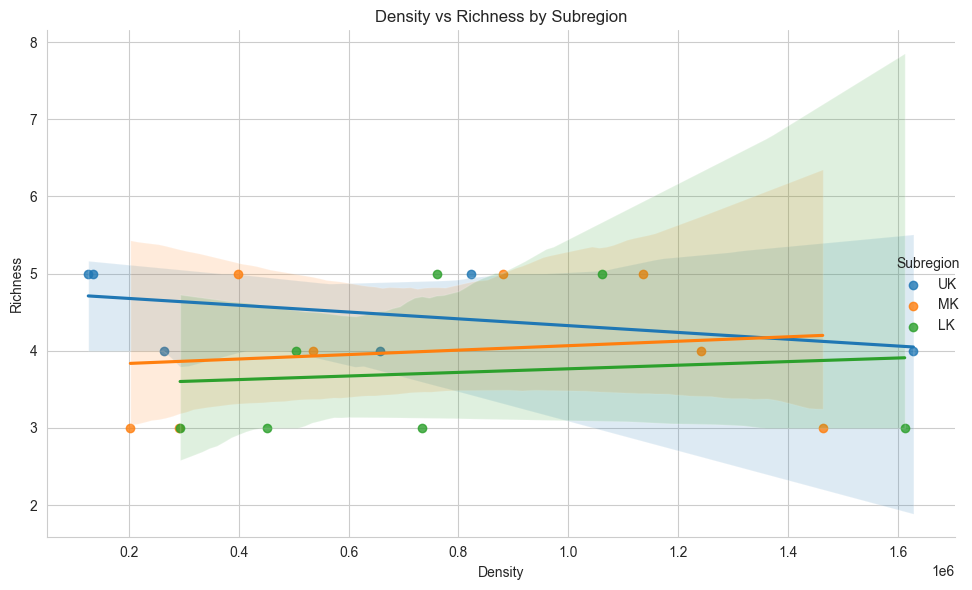

In [23]:
# Add subregion info
site_sub = osc[['Site_name', 'Subregion']].drop_duplicates()
site_metrics = pd.merge(site_metrics, site_sub, on="Site_name", how="left")

plt.figure(figsize=(12, 6))
sns.lmplot(data=site_metrics, x="Density", y="Richness", hue="Subregion", height=6, aspect=1.5)
plt.title("Density vs Richness by Subregion")
plt.tight_layout()
plt.show()


# EDA Environmental Correlations

In [24]:
%store -r core_coral_env

core_coral_env.head()

,StationID,Date,Pseudopterogorgia_americana,Total_Octocorals,Siderastrea_siderea,Siderastrea_siderea_scor_lta,Siderastrea_siderea_scor_density,sciName,Count,SiteID,Site_name,Octocoral,Stony_coral,Substrate,Siderastrea_siderea_scor_cover,TempC,TempF
0,321,2011-06-08,23.8,9.0,18.0,7324.5,1.8,Dichocoenia stokesii,4.0,32.0,Porter Patch,0.1322,0.0416,0.4957,0.0288,27.80,82.04
1,321,2011-06-08,23.8,9.0,18.0,7324.5,1.8,Dichocoenia stokesii,4.0,32.0,Porter Patch,0.1322,0.0416,0.4957,0.0288,27.65,81.77
2,321,2011-06-08,23.8,9.0,18.0,7324.5,1.8,Dichocoenia stokesii,4.0,32.0,Porter Patch,0.1322,0.0416,0.4957,0.0288,27.55,81.59
3,321,2011-06-08,23.8,9.0,18.0,7324.5,1.8,Dichocoenia stokesii,4.0,32.0,Porter Patch,0.1322,0.0416,0.4957,0.0288,27.40,81.33
4,321,2011-06-08,23.8,9.0,18.0,7324.5,1.8,Dichocoenia stokesii,4.0,32.0,Porter Patch,0.1322,0.0416,0.4957,0.0288,27.43,81.37


#### Analyze environmental correlations between octocoral density and water temperature

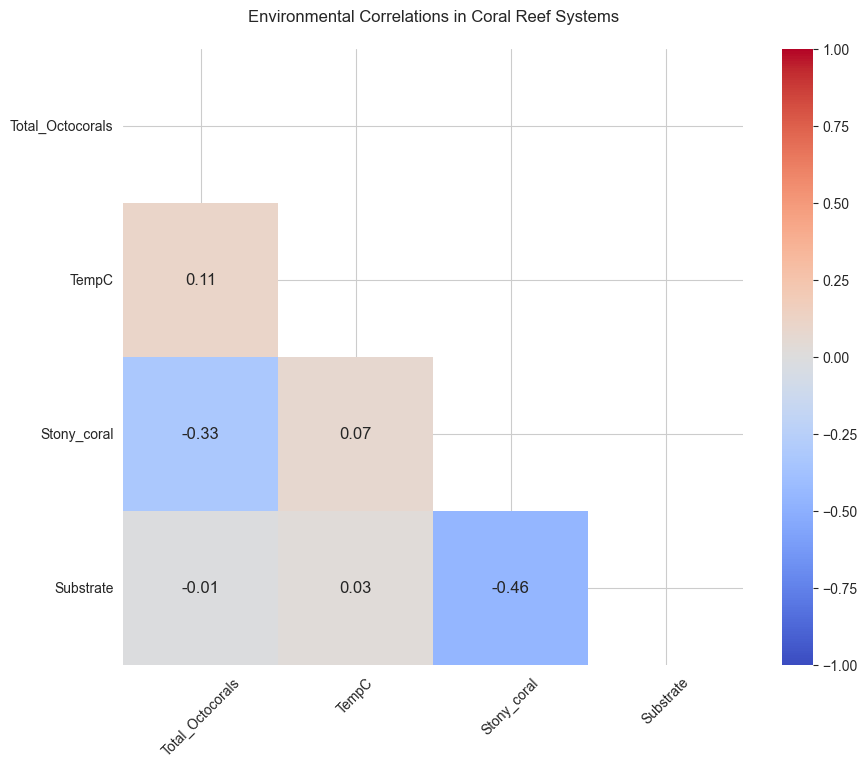

Significant Correlations (p < 0.05):
Total_Octocorals  Stony_coral        -0.327288
Stony_coral       Total_Octocorals   -0.327288
                  Substrate          -0.455852
Substrate         Stony_coral        -0.455852
dtype: float64


In [25]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np

cce = core_coral_env.copy()
# 1. Data Preparation
# Aggregate temperature data (multiple readings per survey)
temp_aggregated = cce.groupby(['StationID', 'Date'])[['TempC']].mean().reset_index()

# Merge with coral data (1 row per survey)
unique_cols = ['StationID', 'Date', 'Total_Octocorals', 'Stony_coral', 'Substrate']
coral_agg = cce[unique_cols].drop_duplicates()

analysis_df = pd.merge(coral_agg, temp_aggregated, on=['StationID', 'Date'])

# 2. Correlation Analysis
# Select relevant variables
variables = ['Total_Octocorals', 'TempC', 'Stony_coral', 'Substrate']

# Calculate correlations with p-values
corr_matrix = analysis_df[variables].corr(method='pearson')
p_matrix = analysis_df[variables].corr(method=lambda x, y: stats.pearsonr(x, y)[1])

# 3. Visualization
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, 
            annot=True, 
            cmap='coolwarm', 
            mask=np.triu(np.ones_like(corr_matrix)),
            fmt=".2f",
            vmin=-1, vmax=1,
            annot_kws={"size": 12})
plt.title("Environmental Correlations in Coral Reef Systems", pad=20)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

# 4. Significant Relationships
print("Significant Correlations (p < 0.05):")
significant = (p_matrix < 0.05) & (abs(corr_matrix) > 0.3)
print(corr_matrix[significant].stack().dropna())

#### Octocoral Relationships

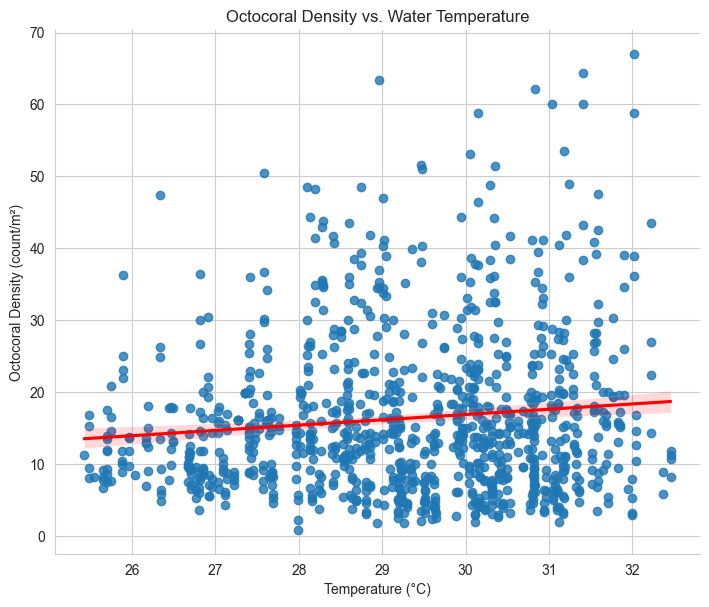

In [26]:
# Scatterplot with regression
sns.lmplot(x='TempC', y='Total_Octocorals', data=analysis_df,
           height=6, aspect=1.2, line_kws={'color': 'red'})
plt.xlabel("Temperature (°C)")
plt.ylabel("Octocoral Density (count/m²)")
plt.title("Octocoral Density vs. Water Temperature")
plt.show()

## Regional Comparison 

In [27]:
# Assuming your DataFrame is called `temporal_trend_data`
dff = core_coral.copy()

# Ensure Date is in datetime format
dff['Date'] = pd.to_datetime(df['Date'])

# Extract year
dff['Year'] = dff['Date'].dt.year
dff.head()

,StationID,Date,Pseudopterogorgia_americana,Total_Octocorals,Siderastrea_siderea,Siderastrea_siderea_scor_lta,Siderastrea_siderea_scor_density,sciName,Count,SiteID,Site_name,Octocoral,Stony_coral,Substrate,Siderastrea_siderea_scor_cover,Year
0,321,2011-06-08,23.8,9.0,18.0,7324.5,1.8,Dichocoenia stokesii,4.0,32.0,Porter Patch,0.1322,0.0416,0.4957,0.0288,2011
1,321,2011-06-08,23.8,9.0,18.0,7324.5,1.8,Montastraea cavernosa,1.0,32.0,Porter Patch,0.1322,0.0416,0.4957,0.0288,2011
2,321,2011-06-08,23.8,9.0,18.0,7324.5,1.8,Porites astreoides,4.0,32.0,Porter Patch,0.1322,0.0416,0.4957,0.0288,2011
3,321,2011-06-08,23.8,9.0,18.0,7324.5,1.8,Porites porites,8.0,32.0,Porter Patch,0.1322,0.0416,0.4957,0.0288,2011
4,321,2011-06-08,23.8,9.0,18.0,7324.5,1.8,Siderastrea radians,1.0,32.0,Porter Patch,0.1322,0.0416,0.4957,0.0288,2011


In [28]:
osc.head()

,StationID,Date,Habitat_x,Subregion,SPP_Code,SiteID,Height_cm,Diameter_cm,Height_cm_scor,Percent_old_mortality,Percent_recent_mortality,LTA_cm2,Site_name,latDD,lonDD,Depth_ft,length_m,Habitat_y,Reef_Type,Year
0,321,2011-06-08,P,UK,PAME,32,9.0,4.0,1.0,0.0,0.0,17.36,Porter Patch,25.1032,-80.3243,15,24,P,Shallow,2011
1,321,2011-06-08,P,UK,PAME,32,9.0,4.0,1.0,0.0,0.0,17.36,Porter Patch,25.1032,-80.3243,14,23,P,Shallow,2011
2,321,2011-06-08,P,UK,PAME,32,9.0,4.0,1.0,0.0,0.0,17.36,Porter Patch,25.1032,-80.3243,16,23,P,Shallow,2011
3,321,2011-06-08,P,UK,PAME,32,9.0,4.0,1.0,0.0,0.0,17.36,Porter Patch,25.1032,-80.3243,17,25,P,Shallow,2011
4,321,2011-06-08,P,UK,PAME,32,9.0,7.0,2.0,0.0,0.0,56.27,Porter Patch,25.1032,-80.3243,15,24,P,Shallow,2011


### Data Integration & Region Mapping

In [44]:
# Get unique region mapping from osc data
region_mapping = osc[['StationID', 'Subregion']].drop_duplicates()

# Merge region information into main dataframe
dff = pd.merge(dff, region_mapping, on='StationID', how='left')

# Clean region names
dff['Subregion'] = dff['Subregion'].replace({'UK':'Upper Keys', 'MK':'Middle Keys', 'LK':'Lower Keys'})

### Regional Aggregation

In [37]:
# Calculate total counts per species-region-year
species_counts = (
    dff.groupby(['Subregion', 'Year', 'sciName'])
    ['Count'].sum()
    .reset_index()
)

# Calculate total counts per region-year
total_counts = dff.groupby(['Subregion', 'Year'])['Count'].sum().reset_index(name='Total')

# Merge and calculate percentages
species_composition = pd.merge(
    species_counts,
    total_counts,
    on=['Subregion', 'Year']
)
species_composition['Percentage'] = 100 * species_composition['Count'] / species_composition['Total']

### Regional Metrics Calculation

In [38]:
regional_metrics = dff.groupby(['Subregion', 'Year']).agg(
    Octocoral_Density=('Total_Octocorals', 'mean'),
    Stony_Coral_Cover=('Stony_coral', 'mean'),
    Substrate_Cover=('Substrate', 'mean')
).reset_index()

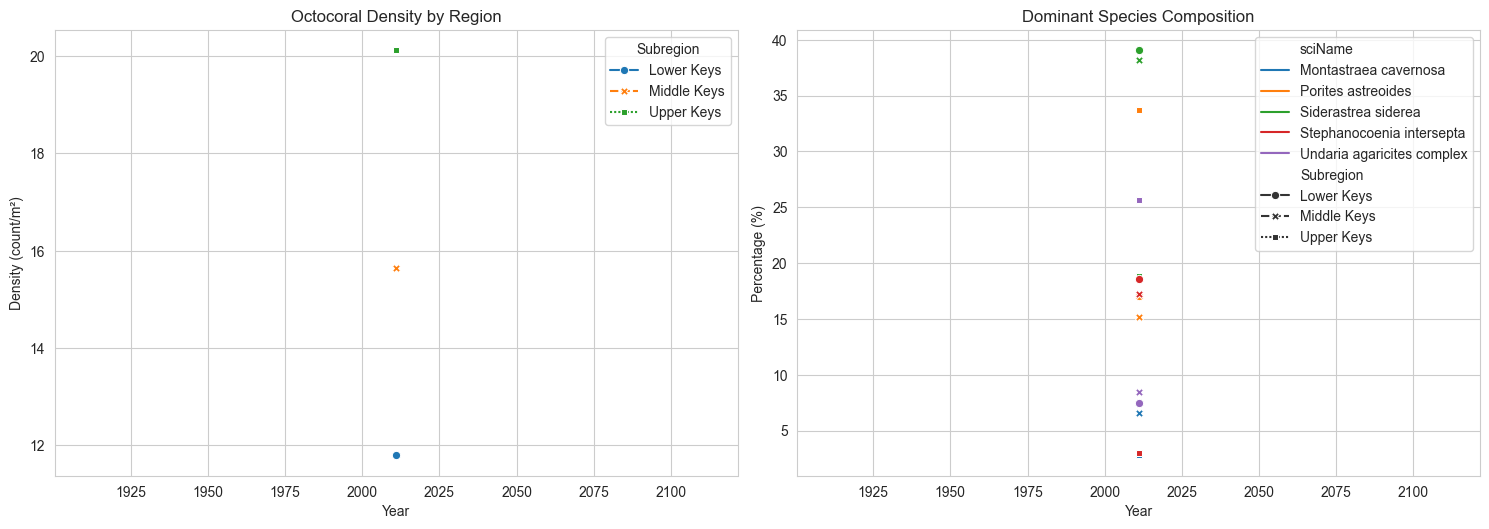

In [39]:
plt.figure(figsize=(15, 10))

# 1. Octocoral Density Trends
plt.subplot(2, 2, 1)
sns.lineplot(
    data=regional_metrics,
    x='Year', y='Octocoral_Density',
    hue='Subregion', style='Subregion',
    markers=True
)
plt.title('Octocoral Density by Region')
plt.ylabel('Density (count/m²)')

# 2. Species Composition
plt.subplot(2, 2, 2)
top_species = species_composition.groupby('sciName')['Percentage'].sum().nlargest(5).index
filtered_data = species_composition[species_composition['sciName'].isin(top_species)]

sns.lineplot(
    data=filtered_data,
    x='Year', y='Percentage',
    hue='sciName', style='Subregion',
    markers=True
)
plt.title('Dominant Species Composition')
plt.ylabel('Percentage (%)')

plt.tight_layout()
plt.show()

### Factors (temperature, pollution, etc.) affecting coral health, density, and richness. Document



In [54]:

import statsmodels.api as sm


# Step 1: Calculate Species Richness
richness = core_coral_env.groupby(['StationID', 'Date'])['sciName'].nunique().reset_index()
richness.rename(columns={'sciName': 'Species_Richness'}, inplace=True)

# Step 2: Aggregate data to one row per StationID and Date
# Take the mean for numeric columns, drop duplicates for others
agg_dict = {
    'Total_Octocorals': 'mean',
    'Siderastrea_siderea_scor_density': 'mean',
    'Stony_coral': 'mean',
    'Substrate': 'mean',
    'TempC': 'mean',
    'Site_name': 'first'  # Keep the first Site_name
}
df_agg = core_coral_env.groupby(['StationID', 'Date']).agg(agg_dict).reset_index()

# Merge Species Richness back into the aggregated dataframe
df_agg = df_agg.merge(richness, on=['StationID', 'Date'], how='left')

# Step 3: Add Subregion from osc (assuming osc is available from prior steps)
# If osc is not available, skip this step or load it
try:
    osc_subset = osc[['StationID', 'Subregion']].drop_duplicates()
    df_agg = df_agg.merge(osc_subset, on='StationID', how='left')
    df_agg['Subregion'] = df_agg['Subregion'].replace({'UK': 'Upper Keys', 'MK': 'Middle Keys', 'LK': 'Lower Keys'})
    df_agg = df_agg.dropna(subset=['Subregion'])
except NameError:
    print("osc dataframe not found. Proceeding without Subregion.")

# Check the prepared data
print("Prepared Data:\n", df_agg.head())

Prepared Data:
    StationID       Date  Total_Octocorals  Siderastrea_siderea_scor_density  \
0        261 2015-08-11              15.7                               5.0   
1        261 2016-08-11              14.4                               5.1   
2        261 2017-08-18              14.6                               7.0   
3        262 2015-08-11              15.4                               6.1   
4        262 2016-08-11               9.6                               6.1   

   Stony_coral  Substrate      TempC     Site_name  Species_Richness  \
0       0.0942     0.3693  31.685833  Red Dun Reef                11   
1       0.1520     0.4854  30.688750  Red Dun Reef                12   
2       0.1538     0.4502  32.046364  Red Dun Reef                13   
3       0.2044     0.3475  31.685833  Red Dun Reef                 9   
4       0.1721     0.4764  30.688750  Red Dun Reef                10   

    Subregion  
0  Lower Keys  
1  Lower Keys  
2  Lower Keys  
3  Lower Key

### Regression Analysis



In [55]:
# Step 1: Prepare predictors and response variables
# Encode Subregion as dummy variables
if 'Subregion' in df_agg.columns:
    df_agg = pd.get_dummies(df_agg, columns=['Subregion'], drop_first=True)

# Define predictors (exclude response variables and non-numeric columns)
predictors = ['TempC', 'Substrate', 'Stony_coral', 'Total_Octocorals']
if 'Subregion' in df_agg.columns:
    predictors.extend([col for col in df_agg.columns if 'Subregion_' in col])
else:
    print("Subregion not included in predictors due to missing data.")

# Step 2: Run regressions for each response variable
response_vars = {
    'Octocoral_Density': 'Total_Octocorals',
    'Stony_Coral_Density': 'Siderastrea_siderea_scor_density',
    'Species_Richness': 'Species_Richness',
    'Stony_Coral_Cover': 'Stony_coral'
}

results = {}
for name, response in response_vars.items():
    # Prepare X and y
    X = df_agg[predictors].copy()
    # Remove the response variable from predictors if it's there
    if response in X.columns:
        X = X.drop(columns=[response])
    y = df_agg[response]
    
    # Add constant for intercept
    X = sm.add_constant(X)
    
    # Run OLS regression
    try:
        model = sm.OLS(y, X).fit()
        results[name] = model
        print(f"\nRegression Results for {name}:\n", model.summary())
    except Exception as e:
        print(f"Error running regression for {name}: {e}")

# Step 3: Extract and Rank Factors
top_factors = {}
for name, model in results.items():
    # Get coefficients and p-values
    coef_df = pd.DataFrame({
        'Coefficient': model.params,
        'P-Value': model.pvalues
    })
    # Filter for significant factors (p < 0.05) and exclude the constant
    significant = coef_df[(coef_df['P-Value'] < 0.05) & (coef_df.index != 'const')]
    # Sort by absolute coefficient value
    significant = significant.reindex(significant['Coefficient'].abs().sort_values(ascending=False).index)
    top_factors[name] = significant.head(5)  # Top 5 factors
    print(f"\nTop Factors for {name}:\n", top_factors[name])

Subregion not included in predictors due to missing data.

Regression Results for Octocoral_Density:
                             OLS Regression Results                            
Dep. Variable:       Total_Octocorals   R-squared:                       0.161
Model:                            OLS   Adj. R-squared:                  0.159
Method:                 Least Squares   F-statistic:                     65.20
Date:                Thu, 24 Apr 2025   Prob (F-statistic):           1.44e-38
Time:                        00:41:54   Log-Likelihood:                -3805.0
No. Observations:                1023   AIC:                             7618.
Df Residuals:                    1019   BIC:                             7638.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
----------------------------

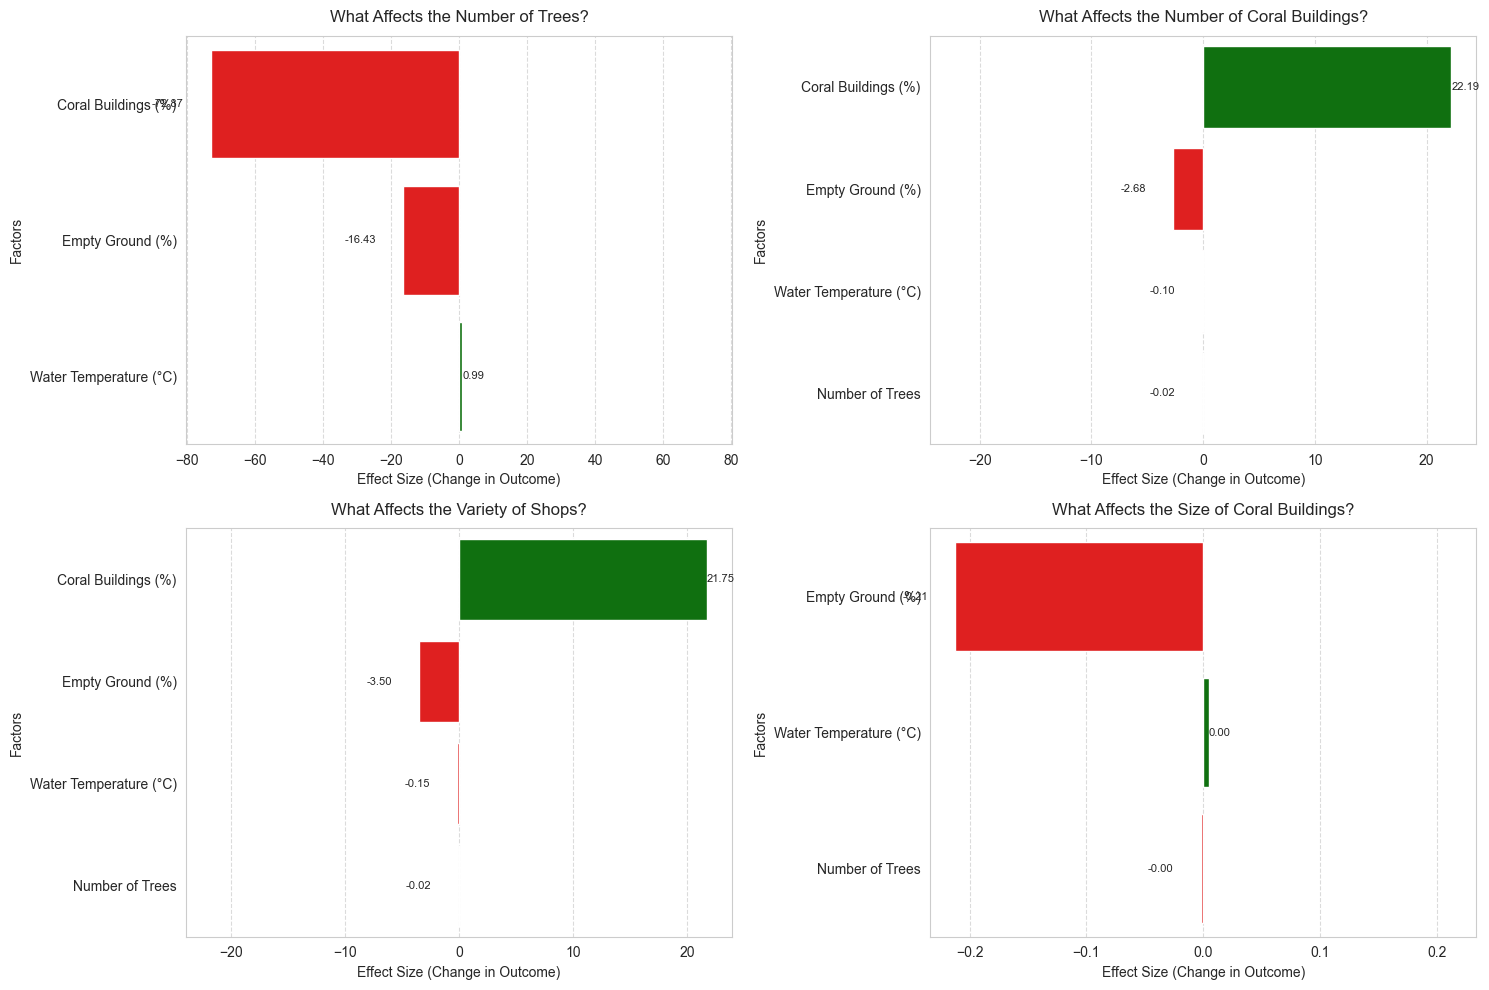

In [58]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming top_factors dictionary is already generated from the regression step
# Map predictor names to descriptive labels for the underwater city analogy
label_mapping = {
    'TempC': 'Water Temperature (°C)',
    'Substrate': 'Empty Ground (%)',
    'Stony_coral': 'Coral Buildings (%)',
    'Total_Octocorals': 'Number of Trees'
}

# Create a figure with subplots for each response variable
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()  # Flatten the 2x2 grid for easier iteration

# Friendly titles for each response variable
title_mapping = {
    'Octocoral_Density': 'What Affects the Number of Trees?',
    'Stony_Coral_Density': 'What Affects the Number of Coral Buildings?',
    'Species_Richness': 'What Affects the Variety of Shops?',
    'Stony_Coral_Cover': 'What Affects the Size of Coral Buildings?'
}

# Plot each response variable
for idx, (name, factors) in enumerate(top_factors.items()):
    # Prepare data for plotting
    factors = factors.copy()
    # Add predictor names as a column
    factors['Predictor'] = factors.index.map(lambda x: label_mapping.get(x, x))
    # Sort by absolute coefficient for better visualization
    factors = factors.sort_values('Coefficient', key=abs, ascending=False)
    
    # Create bar plot
    sns.barplot(
        x='Coefficient', y='Predictor', hue='Coefficient', 
        palette={val: 'green' if val > 0 else 'red' for val in factors['Coefficient']},
        dodge=False, ax=axes[idx], data=factors
    )
    
    # Customize plot
    axes[idx].set_title(title_mapping[name], fontsize=12, pad=10)
    axes[idx].set_xlabel('Effect Size (Change in Outcome)', fontsize=10)
    axes[idx].set_ylabel('Factors', fontsize=10)
    # Remove the legend (hue is just for coloring, not needed in legend)
    axes[idx].get_legend().remove()
    # Add grid for readability
    axes[idx].grid(True, axis='x', linestyle='--', alpha=0.7)
    
    # Adjust x-axis limits to fit the largest coefficient
    max_coef = max(abs(factors['Coefficient'])) * 1.1
    axes[idx].set_xlim(-max_coef, max_coef)
    
    # Add value labels on the bars
    for i, (coef, pval) in enumerate(zip(factors['Coefficient'], factors['P-Value'])):
        # Position the label at the end of the bar
        x_pos = coef if coef > 0 else coef - max_coef * 0.1
        axes[idx].text(x_pos, i, f'{coef:.2f}', 
                       ha='left' if coef > 0 else 'right', 
                       va='center', fontsize=8)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Extract Year from Date
core_coral_env['Year'] = pd.to_datetime(core_coral_env['Date']).dt.year

# Step 2: Aggregate data to one row per StationID and Year
agg_dict = {
    'Total_Octocorals': 'mean',                  # Octocoral density
    'Siderastrea_siderea_scor_density': 'mean',  # Stony coral density
    'Stony_coral': 'mean',                       # Stony coral cover
    'Substrate': 'mean',                         # Substrate cover
    'TempC': 'mean',                             # Average temperature
    'Site_name': 'first'                         # Keep the first Site_name
}
df_agg = core_coral_env.groupby(['StationID', 'Year']).agg(agg_dict).reset_index()

# Step 3: Calculate year-over-year changes
# Sort by StationID and Year to ensure correct differencing
df_agg = df_agg.sort_values(['StationID', 'Year'])

# Calculate differences (e.g., cover drop, temperature spike)
df_agg['Stony_Coral_Drop'] = df_agg.groupby('StationID')['Stony_coral'].diff().shift(-1) * 100  # % drop in cover
df_agg['Octocoral_Drop'] = df_agg.groupby('StationID')['Total_Octocorals'].diff().shift(-1)      # Drop in octocoral density
df_agg['Stony_Density_Drop'] = df_agg.groupby('StationID')['Siderastrea_siderea_scor_density'].diff().shift(-1)  # Drop in stony coral density
df_agg['TempC_Spike'] = df_agg.groupby('StationID')['TempC'].diff() * 100  # Temperature change (°C)

# Step 4: Define major declines
# Stony coral cover: >2% drop in 1 year
df_agg['Major_Stony_Cover_Decline'] = df_agg['Stony_Coral_Drop'] < -2
# Octocoral density: >10% drop relative to previous year
df_agg['Octocoral_Drop_Pct'] = (df_agg['Octocoral_Drop'] / df_agg['Total_Octocorals'].shift(1)) * 100
df_agg['Major_Octocoral_Decline'] = df_agg['Octocoral_Drop_Pct'] < -10
# Stony coral density: >10% drop relative to previous year
df_agg['Stony_Density_Drop_Pct'] = (df_agg['Stony_Density_Drop'] / df_agg['Siderastrea_siderea_scor_density'].shift(1)) * 100
df_agg['Major_Stony_Density_Decline'] = df_agg['Stony_Density_Drop_Pct'] < -10

# Step 5: Handle NaN values
# Check for NaN values in key columns
print("NaN Counts Before Handling:\n", df_agg.isna().sum())

# Drop rows with NaN in decline indicators or predictors
key_columns = [
    'Stony_Coral_Drop', 'Octocoral_Drop', 'Stony_Density_Drop',
    'Major_Stony_Cover_Decline', 'Major_Octocoral_Decline', 'Major_Stony_Density_Decline',
    'TempC_Spike', 'Substrate'
]
df_clean = df_agg.dropna(subset=key_columns)

# Check the cleaned data
print("Shape Before Dropping NaN:", df_agg.shape)
print("Shape After Dropping NaN:", df_clean.shape)
print("Cleaned Data:\n", df_clean.head())

NaN Counts Before Handling:
 StationID                             0
Year                                  0
Total_Octocorals                      0
Siderastrea_siderea_scor_density      0
Stony_coral                           0
Substrate                             0
TempC                                 0
Site_name                             0
Stony_Coral_Drop                     84
Octocoral_Drop                       84
Stony_Density_Drop                   84
TempC_Spike                          84
Major_Stony_Cover_Decline             0
Octocoral_Drop_Pct                   85
Major_Octocoral_Decline               0
Stony_Density_Drop_Pct              105
Major_Stony_Density_Decline           0
dtype: int64
Shape Before Dropping NaN: (1023, 17)
Shape After Dropping NaN: (855, 17)
Cleaned Data:
     StationID  Year  Total_Octocorals  Siderastrea_siderea_scor_density  \
1         261  2016              14.4                               5.1   
4         262  2016               9.6  

In [68]:


# Assuming df_clean was created earlier as:
# df_clean = df_agg.dropna(subset=key_columns)
# Ensure df_clean is a copy to avoid SettingWithCopyWarning
df_clean = df_clean.copy()

# Step 6: Calculate thresholds for predictors
df_clean.loc[:, 'TempC_Threshold'] = df_clean['TempC_Spike'] > 1  # Temperature spike >1°C
df_clean.loc[:, 'Substrate_Increase'] = df_clean.groupby('StationID')['Substrate'].diff() * 100
df_clean.loc[:, 'Substrate_Threshold'] = df_clean['Substrate_Increase'] > 5  # Substrate increase >5%

# Step 7: Identify conditions preceding major declines
df_clean.loc[:, 'Prev_TempC_Threshold'] = df_clean.groupby('StationID')['TempC_Threshold'].shift(1)
df_clean.loc[:, 'Prev_Substrate_Threshold'] = df_clean.groupby('StationID')['Substrate_Threshold'].shift(1)

# Analyze conditions preceding declines
stony_cover_decline_conditions = df_clean[df_clean['Major_Stony_Cover_Decline']].groupby('Year').agg({
    'Prev_TempC_Threshold': 'mean',
    'Prev_Substrate_Threshold': 'mean'
}).reset_index()

octocoral_decline_conditions = df_clean[df_clean['Major_Octocoral_Decline']].groupby('Year').agg({
    'Prev_TempC_Threshold': 'mean',
    'Prev_Substrate_Threshold': 'mean'
}).reset_index()

stony_density_decline_conditions = df_clean[df_clean['Major_Stony_Density_Decline']].groupby('Year').agg({
    'Prev_TempC_Threshold': 'mean',
    'Prev_Substrate_Threshold': 'mean'
}).reset_index()

print("Conditions Preceding Stony Coral Cover Declines:\n", stony_cover_decline_conditions)
print("Conditions Preceding Octocoral Declines:\n", octocoral_decline_conditions)
print("Conditions Preceding Stony Coral Density Declines:\n", stony_density_decline_conditions)

# Step 8: Time-Lagged Correlations
df_clean.loc[:, 'Next_Stony_Coral'] = df_clean.groupby('StationID')['Stony_coral'].shift(-1)
df_clean.loc[:, 'Next_Total_Octocorals'] = df_clean.groupby('StationID')['Total_Octocorals'].shift(-1)
df_clean.loc[:, 'Next_Siderastrea_Density'] = df_clean.groupby('StationID')['Siderastrea_siderea_scor_density'].shift(-1)

# Handle NaN values introduced by shifting
df_clean = df_clean.dropna(subset=['Next_Stony_Coral', 'Next_Total_Octocorals', 'Next_Siderastrea_Density', 
                                   'Prev_TempC_Threshold', 'Prev_Substrate_Threshold'])

lagged_corrs = df_clean[['TempC', 'Substrate', 'Next_Stony_Coral', 'Next_Total_Octocorals', 'Next_Siderastrea_Density']].corr()
print("Lagged Correlations:\n", lagged_corrs[['Next_Stony_Coral', 'Next_Total_Octocorals', 'Next_Siderastrea_Density']])

Conditions Preceding Stony Coral Cover Declines:
    Year Prev_TempC_Threshold Prev_Substrate_Threshold
0  2013                  NaN                      NaN
1  2014             0.166667                      0.0
2  2015                  1.0                 0.222222
3  2016                  0.0                      0.0
4  2017             0.466667                 0.066667
5  2018                  0.5                 0.166667
6  2019             0.272727                 0.545455
7  2020                  0.0                      1.0
8  2021             0.666667                 0.166667
Conditions Preceding Octocoral Declines:
    Year Prev_TempC_Threshold Prev_Substrate_Threshold
0  2013                  NaN                      NaN
1  2014             0.380952                      0.0
2  2015             0.851852                  0.37037
3  2016             0.578947                 0.263158
4  2017             0.272727                 0.340909
5  2018                  0.6                

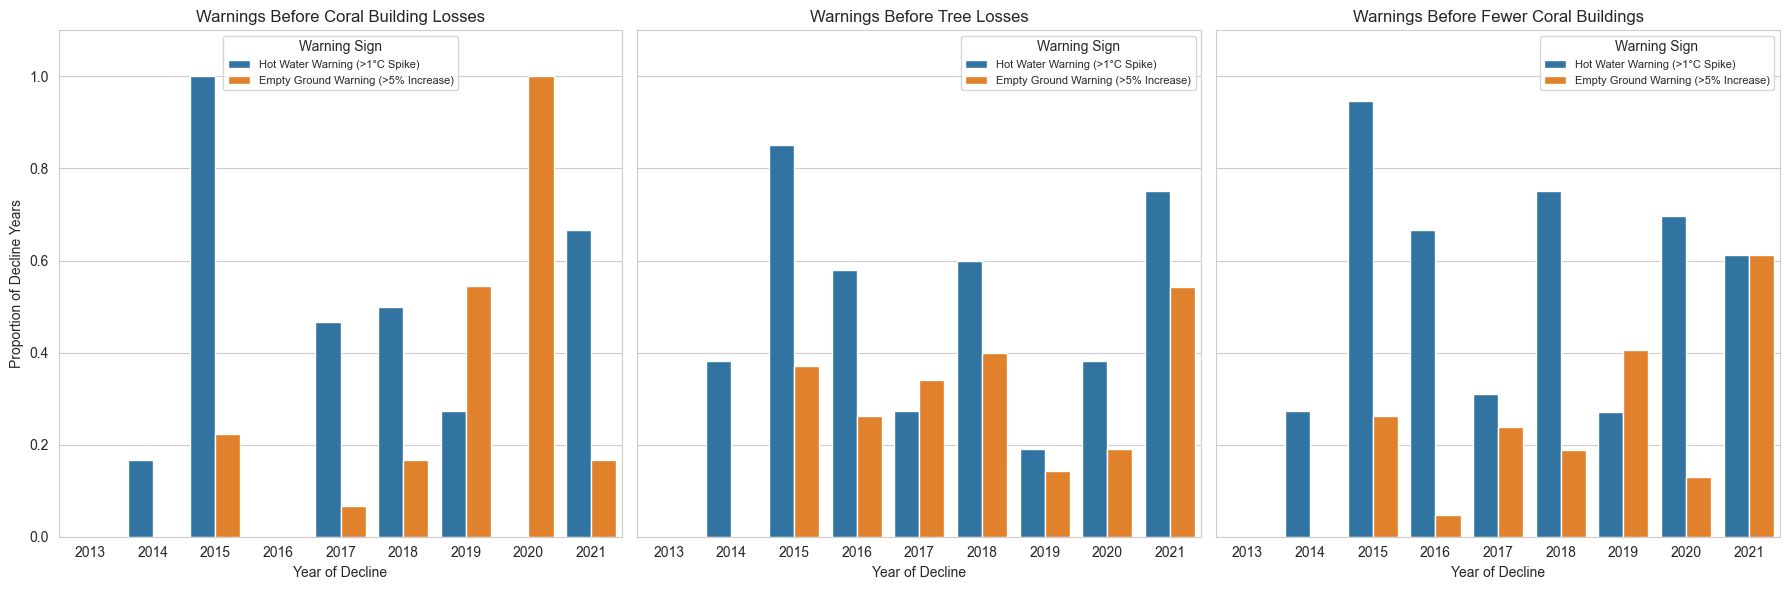

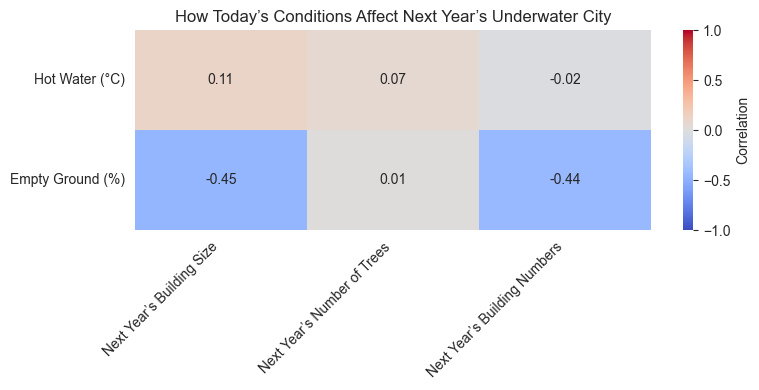

In [69]:


# Step 1: Bar Plots for Conditions Preceding Declines
# Prepare data for plotting (melt the DataFrames for easier plotting with seaborn)
stony_cover_melted = stony_cover_decline_conditions.melt(id_vars='Year', 
                                                         value_vars=['Prev_TempC_Threshold', 'Prev_Substrate_Threshold'],
                                                         var_name='Condition', value_name='Proportion')
stony_cover_melted['Condition'] = stony_cover_melted['Condition'].replace({
    'Prev_TempC_Threshold': 'Hot Water Warning (>1°C Spike)',
    'Prev_Substrate_Threshold': 'Empty Ground Warning (>5% Increase)'
})

octocoral_melted = octocoral_decline_conditions.melt(id_vars='Year', 
                                                     value_vars=['Prev_TempC_Threshold', 'Prev_Substrate_Threshold'],
                                                     var_name='Condition', value_name='Proportion')
octocoral_melted['Condition'] = octocoral_melted['Condition'].replace({
    'Prev_TempC_Threshold': 'Hot Water Warning (>1°C Spike)',
    'Prev_Substrate_Threshold': 'Empty Ground Warning (>5% Increase)'
})

stony_density_melted = stony_density_decline_conditions.melt(id_vars='Year', 
                                                             value_vars=['Prev_TempC_Threshold', 'Prev_Substrate_Threshold'],
                                                             var_name='Condition', value_name='Proportion')
stony_density_melted['Condition'] = stony_density_melted['Condition'].replace({
    'Prev_TempC_Threshold': 'Hot Water Warning (>1°C Spike)',
    'Prev_Substrate_Threshold': 'Empty Ground Warning (>5% Increase)'
})

# Create subplots for the three decline types
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# Plot 1: Stony Coral Cover Declines
sns.barplot(data=stony_cover_melted, x='Year', y='Proportion', hue='Condition', ax=axes[0])
axes[0].set_title('Warnings Before Coral Building Losses', fontsize=12)
axes[0].set_ylabel('Proportion of Decline Years', fontsize=10)
axes[0].set_xlabel('Year of Decline', fontsize=10)
axes[0].set_ylim(0, 1.1)
axes[0].legend(title='Warning Sign', fontsize=8)

# Plot 2: Octocoral Declines
sns.barplot(data=octocoral_melted, x='Year', y='Proportion', hue='Condition', ax=axes[1])
axes[1].set_title('Warnings Before Tree Losses', fontsize=12)
axes[1].set_ylabel('')
axes[1].set_xlabel('Year of Decline', fontsize=10)
axes[1].set_ylim(0, 1.1)
axes[1].legend(title='Warning Sign', fontsize=8)

# Plot 3: Stony Coral Density Declines
sns.barplot(data=stony_density_melted, x='Year', y='Proportion', hue='Condition', ax=axes[2])
axes[2].set_title('Warnings Before Fewer Coral Buildings', fontsize=12)
axes[2].set_ylabel('')
axes[2].set_xlabel('Year of Decline', fontsize=10)
axes[2].set_ylim(0, 1.1)
axes[2].legend(title='Warning Sign', fontsize=8)

plt.tight_layout()
plt.show()

# Step 2: Heatmap for Lagged Correlations
# Prepare the correlation matrix for plotting
corr_matrix = lagged_corrs[['Next_Stony_Coral', 'Next_Total_Octocorals', 'Next_Siderastrea_Density']].loc[['TempC', 'Substrate']]

# Rename columns and index for the underwater city analogy
corr_matrix.columns = ['Next Year’s Building Size', 'Next Year’s Number of Trees', 'Next Year’s Building Numbers']
corr_matrix.index = ['Hot Water (°C)', 'Empty Ground (%)']

# Create the heatmap
plt.figure(figsize=(8, 4))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0, 
            fmt='.2f', annot_kws={'size': 10}, cbar_kws={'label': 'Correlation'})
plt.title('How Today’s Conditions Affect Next Year’s Underwater City', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [64]:
# Drop NaN rows after lagged variables
df_clean = df_clean.dropna(subset=['Prev_TempC_Threshold', 'Prev_Substrate_Threshold', 'Next_Stony_Coral', 'Next_Total_Octocorals', 'Next_Siderastrea_Density'])
print("Shape After Dropping NaN in Lagged Variables:", df_clean.shape)

Shape After Dropping NaN in Lagged Variables: (531, 25)
